# Backpropagation
(In the context of fully-connected neural networks)  

**Mathematical background:**  
Following the most common literature notation, exponents denote layers and subscripts denote vector components. In case of weights they denote the weight connecting a node of the previous layer to a node of the next (written backwards), i.e. $w_{jk}^{l}$ is the weight connecting the node $k$ of layer $l-1$ to the node $j$ of layer $l$.

![](./neural-network.png)

Activation: $a_j^{l+1} = \sigma(z_j^{l+1}) = \sigma\left(\sum\limits_{k=0}^{n_{l}} w_{jk}^{l+1} a_k^l\right)$  
where the bias is incorporated in the weights after augmenting $a^l$ by an extra component equal to 1.

The cost function $C$ is a fuction (MSE, Cross-entropy, etc) of the final activation layer and the true labels: $C = C(a^L, y)$  
What we are looking for is the derivative of the cost w.r.t. the weights:  

$
\large \frac{ \partial C }{ \partial w_{jk}^{l} } = \frac{ \partial C }{ \partial a_{j}^{l} } \cdot \frac{ \partial a_j^l }{ \partial z_{j}^{l} } \cdot \frac{ \partial z_j^l }{ \partial w_{jk}^{l} } = \frac{ \partial C }{ \partial a_{j}^{l} } \cdot \sigma^\prime(z_{j}^{l}) \cdot a_{k}^{l-1}
$  

All derivatives are easy to compute except $\large \frac{ \partial C }{ \partial a_{j}^{l} }$. For this one though we can find a recursive formula by applying the chain rule:  

$\large \frac{ \partial C }{ \partial a_{k}^{l} } = \sum\limits_{j} \frac{ \partial C }{ \partial a_{j}^{l+1} } \cdot \frac{ \partial a_{j}^{l+1} }{ \partial z_{j}^{l+1} } \cdot \frac{ \partial z_{j}^{l+1} }{ \partial a_{k}^{l} } = \sum\limits_{j} \frac{ \partial C }{ \partial a_{j}^{l+1} } \cdot \sigma^\prime(z_{j}^{l+1}) \cdot w_{jk}^{l+1}
$ 


The summation combines the effect of the node $k$ of layer $l$ to all the nodes of layer $l+1$.  

This is it.  
We expressed the derivative we are interested in, in terms of the derivative of the next layer. So by starting from the last layer and going backwards we can calculate all needed derivatives.  

What we finally need is these equations in vector/matrix form so that our implementation is efficient.  
Given the weight matrix:  
$
W^{l+1} = (w_{jk}^{l+1}) = 
\begin{bmatrix}
w_{11} & w_{12} & \cdots w_{1n_{l}} \\
w_{21} & w_{22} & \cdots w_{1n_{l}} \\
\vdots & & \vdots \\
w_{n_{l+1}1} & w_{n_{l+1}2} & \cdots  w_{n_{l+1}n_{l}} \\
\end{bmatrix}
$

we can write $\nabla_{a^{l}} C = [\frac{ \partial C }{ \partial a_{1}^{l} }, \frac{ \partial C }{ \partial a_{2}^{l} }, \cdots]^T$ as:

$
\large \nabla_{a^{l}} C = (W^{l+1})^T \cdot (\nabla_{a^{l+1}} C) \odot \sigma^\prime(z^{l+1})
$

Finally, the scalar-by-matrix derivative of cost w.r.t. the weight matrix is:  
$
\large \nabla_{W^{l}} C = ( (\nabla_{a^{l}} C) \odot\sigma^\prime(z^{l}) ) \cdot (a^{l-1})^T
$

In [1]:
%%html
<style>.container {width: 98%}</style>

In [2]:
%load_ext autoreload
%autoreload 2

In [13]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import OneHotEncoder

import sys
sys.path.insert(0, "../")
from fromscratch.supervised.neuralnetworks.nn import NN, Linear
from fromscratch.supervised.neuralnetworks.loss import Loss, mse, crossentropy, softmax
from fromscratch.supervised.neuralnetworks.activations import relu

### Create some synthetic data

In [6]:
N = 100
dim = 1
X = np.random.random((N, dim))
X = np.sort(X, axis=0)
y = 2*X*X + 1  # for regression
y = y.T[0]

y_c = ((y > y.mean()) & (y < 0.8*y.max())).astype(int)  # for classification
y_c_oh = OneHotEncoder(sparse=False).fit_transform(y_c[:, None])

### Regression task

In [7]:
net1 = NN(layers=[
    Linear(10, input_size=2),
    Linear(10),
    Linear(10),
    Linear(1)
])
net1

Fead-forward Neural Network
---------------------------
4 layers: [10, 10, 10, 1]

       Inputs
       \ | /
 o o o o o o o o o o 
       \ | /
 o o o o o o o o o o 
       \ | /
 o o o o o o o o o o 
          | 
          o 
       Outputs


In [8]:
loss = Loss(net1, mse)

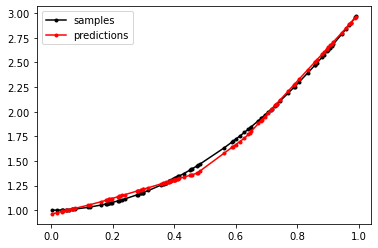

In [9]:
lr = 1e-5

for epoch in range(5000):
    loss.backward(X, y)
    
    for layer in range(net1.n_layers-1):
        grad_w = net1.layers[layer].grad_w
        net1.layers[layer].weights = net1.layers[layer].weights - lr * grad_w


plt.plot(X.T[0], y, marker=".", c="k", label="samples")
plt.plot(X.T[0], net1.forward(X), marker=".", c="r", label="predictions")
plt.legend()

### Classification task

In [10]:
net2 = NN(layers=[
    Linear(10, input_size=2),
    Linear(10),
    Linear(2)
])
net2

Fead-forward Neural Network
---------------------------
3 layers: [10, 10, 2]

       Inputs
       \ | /
 o o o o o o o o o o 
       \ | /
 o o o o o o o o o o 
       \  /
       o o 
       Outputs


In [14]:
loss = Loss(net2, partial(crossentropy, y2_normalized=False))

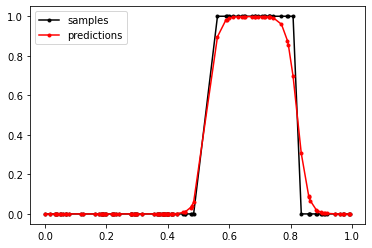

In [23]:
lr = 1e-3

for epoch in range(1000):
    loss.backward(X, y_c_oh)
    
    for layer in range(net2.n_layers-1):
        grad_w = net2.layers[layer].grad_w
        net2.layers[layer].weights = net2.layers[layer].weights - lr * grad_w


plt.plot(X.T[0], y_c_oh[:, 1], marker=".", c="k", label="samples")
plt.plot(X.T[0], softmax(net2.forward(X))[:, 1], marker=".", c="r", label="predictions")
plt.legend()